In [1]:
# %pip install numpy
# %pip install matplotlib
# %pip install matplotlib
# %pip install torch
# %pip install scikit-learn
# %pip install torchvision
# %pip install tqdm
# %pip install timm

In [2]:
# 1. Import libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image, ImageFile
from tqdm import tqdm
import torchvision.models as models
import timm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, accuracy_score, precision_score, recall_score, f1_score


import seaborn as sns
import pandas as pd


ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# 2. Path dataset
train_path = "/kaggle/input/fracturedataset/Bone_Fracture_Binary_Classification/train"
val_path = "/kaggle/input/fracturedataset/Bone_Fracture_Binary_Classification/val"
test_path = "/kaggle/input/fracturedataset/Bone_Fracture_Binary_Classification/test"

In [4]:
# 3. Hàm lấy đường dẫn ảnh
def get_image_paths(folder_path):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

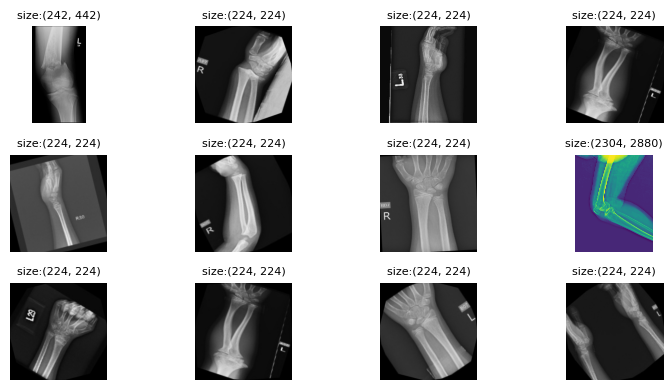

In [5]:
# 4. Hàm hiển thị dữ liệu
def display_dataset(path, num_images=12):
    random.seed(322)
    images_paths = get_image_paths(path)
    random_images = random.sample(images_paths, num_images)
    fig, axes = plt.subplots(3, 4, figsize=(8, 4))

    for i, ax in enumerate(axes.flat):
        image_path = random_images[i]
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"size:{image.size}", fontsize=8)

    plt.tight_layout()
    plt.show()

display_dataset(val_path)

In [6]:
# 5. Xử lý hình ảnh RGBA, LA, P
class HandleTransparency(object):
    def __call__(self, img):
        if img.mode == 'RGBA' or img.mode == 'LA':
            img = img.convert('L')
        elif img.mode == 'P':
            img = img.convert('RGBA')
            img = img.convert('L')
        else:
            img = img.convert('L')
        return img

In [7]:
# 6. Transforms
train_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [8]:
# 7. Load datasets
train_ds = ImageFolder(train_path, transform=train_transforms)
val_ds = ImageFolder(val_path, transform=val_transforms)

In [9]:
print(f"Số lượng lớp trong tập huấn luyện: {len(train_ds.classes)}")
print(f"Các lớp trong tập huấn luyện: {train_ds.classes}")
print(f"Số lượng lớp trong tập kiểm tra: {len(val_ds.classes)}")
print(f"Các lớp trong tập kiểm tra: {val_ds.classes}")

Số lượng lớp trong tập huấn luyện: 2
Các lớp trong tập huấn luyện: ['fractured', 'not fractured']
Số lượng lớp trong tập kiểm tra: 2
Các lớp trong tập kiểm tra: ['fractured', 'not fractured']


In [10]:
train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=64, shuffle=False)

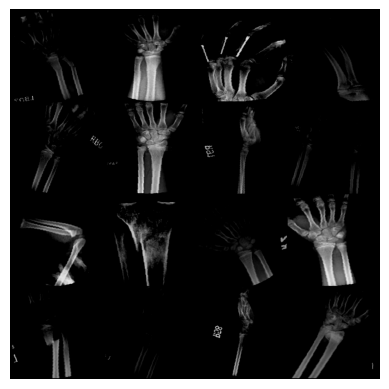

In [11]:
# 8. Xem thử batch ảnh
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

dataiter = iter(train_dataloader)
images, _ = next(dataiter)
imshow(vutils.make_grid(images[:16], nrow=4))

In [12]:
# 9. Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
from torchvision.models import densenet121

# 10 Load DenseNet121 từ torchvision
model = densenet121(pretrained=True)

# Sửa lớp đầu vào để nhận ảnh grayscale (1 channel)
model.features.conv0 = nn.Conv2d(
    in_channels=1,
    out_channels=model.features.conv0.out_channels,
    kernel_size=model.features.conv0.kernel_size,
    stride=model.features.conv0.stride,
    padding=model.features.conv0.padding,
    bias=(model.features.conv0.bias is not None)
)

# Đóng băng toàn bộ model
for param in model.parameters():
    param.requires_grad = False

# Cho phép fine-tune DenseBlock cuối
for param in model.features.denseblock4.parameters():
    param.requires_grad = True

# Thay classifier
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, 2)
)

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 211MB/s]


In [14]:
# 11. Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()

# Chỉ train phần requires_grad=True
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-4, 
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

In [15]:
def train_one_epoch(model, train_dataloader, criterion, optimizer):
    model.train()
    total_loss = 0

    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

In [16]:
def validate(model, val_dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / len(val_dataloader.dataset)
    avg_loss = total_loss / len(val_dataloader)

    return avg_loss, accuracy, all_labels, all_predictions


In [17]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs=20):
    train_losses = []
    val_losses = []
    accuracies = []
    all_labels = []
    all_predictions = []

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer)
        val_loss, accuracy, epoch_labels, epoch_predictions = validate(model, val_dataloader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracies.append(accuracy)

        all_labels.extend(epoch_labels)
        all_predictions.extend(epoch_predictions)

        scheduler.step()

        print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Accuracy: {accuracy:.2f}%')

    return train_losses, val_losses, accuracies, all_labels, all_predictions

In [18]:
train_losses, val_losses, accuracies, all_labels, all_predictions = train(
    model, train_dataloader, val_dataloader, criterion, optimizer, scheduler
)

 31%|███       | 4/13 [00:04<00:09,  1.03s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 13/13 [00:13<00:00,  1.03s/it]


Epoch: 1/20 | Train Loss: 0.4085 | Val Loss: 0.2360 | Accuracy: 89.38%


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


Epoch: 2/20 | Train Loss: 0.1344 | Val Loss: 0.1412 | Accuracy: 94.33%


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch: 3/20 | Train Loss: 0.0674 | Val Loss: 0.0903 | Accuracy: 96.98%


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


Epoch: 4/20 | Train Loss: 0.0478 | Val Loss: 0.0677 | Accuracy: 97.83%


100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Epoch: 5/20 | Train Loss: 0.0344 | Val Loss: 0.0796 | Accuracy: 97.47%


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch: 6/20 | Train Loss: 0.0272 | Val Loss: 0.1065 | Accuracy: 96.50%


100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Epoch: 7/20 | Train Loss: 0.0257 | Val Loss: 0.0693 | Accuracy: 97.83%


100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


Epoch: 8/20 | Train Loss: 0.0224 | Val Loss: 0.0493 | Accuracy: 98.43%


100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


Epoch: 9/20 | Train Loss: 0.0219 | Val Loss: 0.0533 | Accuracy: 98.19%


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch: 10/20 | Train Loss: 0.0158 | Val Loss: 0.0477 | Accuracy: 98.31%


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


Epoch: 11/20 | Train Loss: 0.0156 | Val Loss: 0.0504 | Accuracy: 98.19%


100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


Epoch: 12/20 | Train Loss: 0.0134 | Val Loss: 0.0436 | Accuracy: 98.43%


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


Epoch: 13/20 | Train Loss: 0.0120 | Val Loss: 0.0408 | Accuracy: 98.43%


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


Epoch: 14/20 | Train Loss: 0.0129 | Val Loss: 0.0389 | Accuracy: 98.55%


100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


Epoch: 15/20 | Train Loss: 0.0130 | Val Loss: 0.0388 | Accuracy: 98.55%


100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Epoch: 16/20 | Train Loss: 0.0135 | Val Loss: 0.0383 | Accuracy: 98.55%


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


Epoch: 17/20 | Train Loss: 0.0120 | Val Loss: 0.0386 | Accuracy: 98.55%


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch: 18/20 | Train Loss: 0.0154 | Val Loss: 0.0383 | Accuracy: 98.79%


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch: 19/20 | Train Loss: 0.0117 | Val Loss: 0.0408 | Accuracy: 98.31%


100%|██████████| 13/13 [00:08<00:00,  1.62it/s]

Epoch: 20/20 | Train Loss: 0.0116 | Val Loss: 0.0401 | Accuracy: 98.55%


In [19]:
import os

# Đường dẫn thư mục bạn muốn lưu
save_dir = 'FracturedDataDenseNet'

# Nếu thư mục chưa tồn tại thì tạo mới
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, 'model.pt')

torch.save(model.state_dict(), save_path)

print(f"Model đã được lưu tại {save_path}")


Model đã được lưu tại FracturedDataDenseNet/model.pt


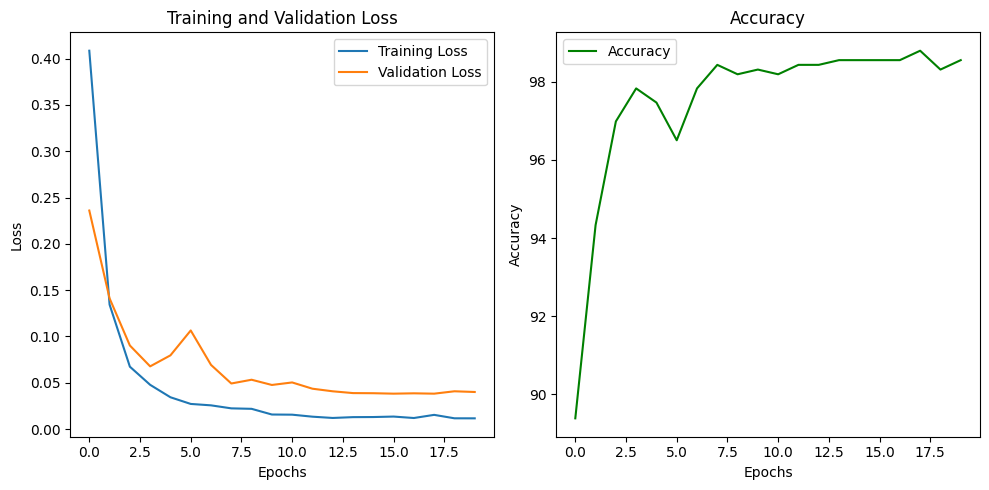

In [20]:
def plot_curves(train_losses, val_losses, accuracies):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy', color='green')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_curves(train_losses, val_losses, accuracies)

In [21]:
def predict_image(image_path, model, transforms, device):
    image = Image.open(image_path)
    image = transforms(image).unsqueeze(0)  # Thêm batch dimension

    image = image.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

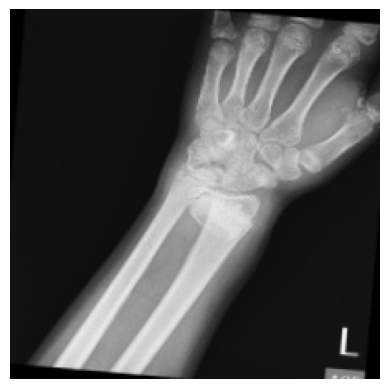

predict: 0 (fractured)
true label: fractured


In [22]:
image_path = random.choice(get_image_paths(test_path))
plt.imshow(Image.open(image_path))
plt.axis('off')
plt.show()

predicted_class = predict_image(image_path, model, val_transforms, device)
true_class = image_path.split('/')[-2]

print(f"predict: {predicted_class} ({train_ds.classes[predicted_class]})")
print(f"true label: {true_class}")

In [23]:
test_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Thêm normalize giống train
])

test_ds = ImageFolder(test_path, transform=test_transforms)
test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=False)


In [24]:
def measure_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy

print(f"Validation Accuracy: {measure_accuracy(model, val_dataloader):.2f}%")
print(f"Test Accuracy: {measure_accuracy(model, test_dataloader):.2f}%")


Validation Accuracy: 98.55%
Test Accuracy: 98.22%


In [25]:
def get_predictions(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred


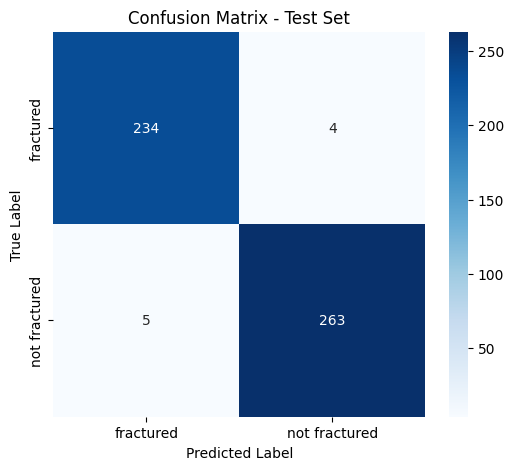

In [26]:
y_true, y_pred = get_predictions(model, test_dataloader)

# Tên lớp lấy từ test dataset
class_names = test_ds.classes

# Tạo confusion matrix
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(6, 5))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.show()


In [27]:
# In classification report chi tiết theo từng lớp
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# In tổng hợp các chỉ số chung (macro)
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("=== Overall Metrics (Macro Average) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


=== Classification Report ===
               precision    recall  f1-score   support

    fractured       0.98      0.98      0.98       238
not fractured       0.99      0.98      0.98       268

     accuracy                           0.98       506
    macro avg       0.98      0.98      0.98       506
 weighted avg       0.98      0.98      0.98       506

=== Overall Metrics (Macro Average) ===
Accuracy : 0.9822
Precision: 0.9820
Recall   : 0.9823
F1 Score : 0.9822
